In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import tensorflow_datasets as tfds
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, InputLayer, Flatten, BatchNormalization, Layer, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras import Model

In [ ]:
dataset, dataset_info = tfds.load('malaria', with_info=True, as_supervised=True, shuffle_files=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/27558 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/malaria/1.0.0.incomplete0GDH3G/malaria-train.tfrecord*...:   0%|          …

Dataset malaria downloaded and prepared to /root/tensorflow_datasets/malaria/1.0.0. Subsequent calls will reuse this data.


In [ ]:
# Creating a function for dataset split
def dataset_split(dataset, train_ratio, test_ratio, val_ratio):
  '''
  This function use to split dataset into train, test and validation dataset.
  And it's returns train, test, validation datasets.
  Arg:
    dataset: the dataset you have.
    train ratio: train dataset ratio between 0-1 where 1 represent 100%.
    test ratio: test dataset ratio 0-1.
    val_ration: validation data ratio 0-1.

  '''
  #main_dataset
  #print(list(dataset.as_numpy_iterator()))
  dataset_size = len(dataset)

  # for training dataset
  train_dataset = dataset.take(int(dataset_size*train_ratio))
  #print(list(train_dataset.as_numpy_iterator()))

  # for test dataset
  test_dataset_list = dataset.skip(int(dataset_size * train_ratio))
  test_dataset = test_dataset_list.take(int(dataset_size * test_ratio))
  #print(list(test_dataset_list.as_numpy_iterator()))
  #print(list(test_dataset.as_numpy_iterator()))

  # For validation dataset
  val_dataset = test_dataset_list.skip(int(dataset_size * test_ratio))
  #print(list(val_dataset.as_numpy_iterator()))

  return train_dataset, test_dataset, val_dataset

In [ ]:
# Calling the dataset_split function
train_dataset, test_dataset, val_dataset = dataset_split(dataset['train'], train_ratio=.7, test_ratio=.15, val_ratio=.15)

In [ ]:
for data in train_dataset.take(2):
  print(data)

(<tf.Tensor: shape=(103, 103, 3), dtype=uint8, numpy=
array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)>, <tf.Tensor: shape=(), dtype=int64, numpy=0>)
(<tf.Tensor: shape=(115, 157, 3), dtype=uint8, numpy=
array([[[0, 0, 0],
        [0, 0, 0],
       

In [ ]:
print(len(train_dataset), len(test_dataset), len(val_dataset))

19290 4133 4135


In [ ]:
print(len(dataset['train']))

27558


Data Visualization

In [ ]:
train_dataset

<_TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

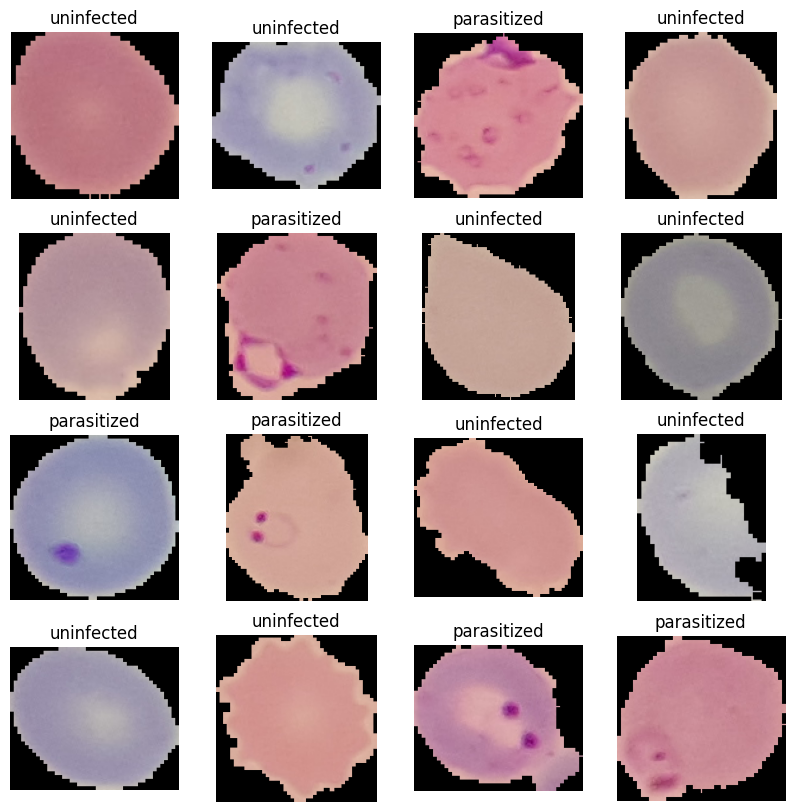

In [ ]:
plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(train_dataset.take(16)):
  plt.subplot(4, 4, i+1)
  plt.imshow(image)
  plt.title(dataset_info.features['label'].int2str(label))
  plt.axis('off')

In [ ]:
dataset_info

tfds.core.DatasetInfo(
    name='malaria',
    full_name='malaria/1.0.0',
    description="""
    The Malaria dataset contains a total of 27,558 cell images with equal instances
    of parasitized and uninfected cells from the thin blood smear slide images of
    segmented cells.
    """,
    homepage='https://lhncbc.nlm.nih.gov/publication/pub9932',
    data_dir=PosixGPath('/tmp/tmpgyx7m8wktfds'),
    file_format=tfrecord,
    download_size=337.08 MiB,
    dataset_size=317.62 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=27558, num_shards=4>,
    },
    citation="""@article{rajaraman2018pre,
      title={Pre-trained convolutional neural networks as feature extractors toward
      improved malaria parasite detection in thin blood smear images},


Data Preprocessing

In [ ]:
img_size = 224
# creating a function for resize and rescale dataset
def resize_rescale(image, label):
  return tf.image.resize(image, (img_size, img_size))/255.0, label

In [ ]:
train_dataset = train_dataset.map(resize_rescale)
test_dataset = test_dataset.map(resize_rescale)
val_dataset = val_dataset.map(resize_rescale)

In [ ]:
for image, label in enumerate(train_dataset.take(1)):
  print(image, label)

0 (<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
array([[[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       ...,

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]], dtype=float32)>, <tf.Tensor: shape=(), dtype=in

In [ ]:
train_dataset = train_dataset.shuffle(buffer_size=8, reshuffle_each_iteration=True).batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.shuffle(buffer_size=8, reshuffle_each_iteration=True).batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [ ]:
test_dataset

<_MapDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [ ]:
val_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

Model Creation

Sequential API

In [ ]:
model = tf.keras.Sequential([
    InputLayer(input_shape=(img_size, img_size, 3)),
    Conv2D(filters=6, kernel_size=5, strides=(1, 1), padding='valid', activation='relu'),
    BatchNormalization(),
    MaxPool2D(pool_size=(2, 2), strides=2),

    Conv2D(filters=16, kernel_size=5, strides=(1, 1), padding='valid', activation='relu'),
    BatchNormalization(),
    MaxPool2D(pool_size=(2, 2), strides=2),

    Flatten(),
    Dense(100, activation='relu'),
    BatchNormalization(),
    Dense(10, activation='relu'),
    Dense(1, activation='sigmoid')


])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 220, 220, 6)       456       
                                                                 
 batch_normalization (Batch  (None, 220, 220, 6)       24        
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 110, 110, 6)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 106, 106, 16)      2416      
                                                                 
 batch_normalization_1 (Bat  (None, 106, 106, 16)      64        
 chNormalization)                                                
                                                        

In [ ]:
# compile the model
model.compile(
    optimizer = Adam(lr=0.001),
    loss = BinaryCrossentropy(),
    metrics = 'accuracy'
)

In [ ]:
history = model.fit(
    train_dataset,
    validation_data = val_dataset,
    epochs = 15
)

Epoch 1/15
603/603 [==============================] - 85s 122ms/step - loss: 0.4848 - accuracy: 0.7629 - val_loss: 0.4628 - val_accuracy: 0.8053
Epoch 2/15
603/603 [==============================] - 46s 77ms/step - loss: 0.2142 - accuracy: 0.9229 - val_loss: 0.6103 - val_accuracy: 0.7299
Epoch 3/15
603/603 [==============================] - 41s 68ms/step - loss: 0.1569 - accuracy: 0.9449 - val_loss: 0.2231 - val_accuracy: 0.9180
Epoch 4/15
603/603 [==============================] - 46s 77ms/step - loss: 0.1233 - accuracy: 0.9573 - val_loss: 0.2050 - val_accuracy: 0.9245
Epoch 5/15
603/603 [==============================] - 41s 67ms/step - loss: 0.1362 - accuracy: 0.9486 - val_loss: 0.4555 - val_accuracy: 0.8815
Epoch 6/15
603/603 [==============================] - 41s 69ms/step - loss: 0.1096 - accuracy: 0.9596 - val_loss: 0.2048 - val_accuracy: 0.9391
Epoch 7/15
603/603 [==============================] - 43s 71ms/step - loss: 0.0688 - accuracy: 0.9743 - val_loss: 0.2252 - val_accuracy

<Axes: >

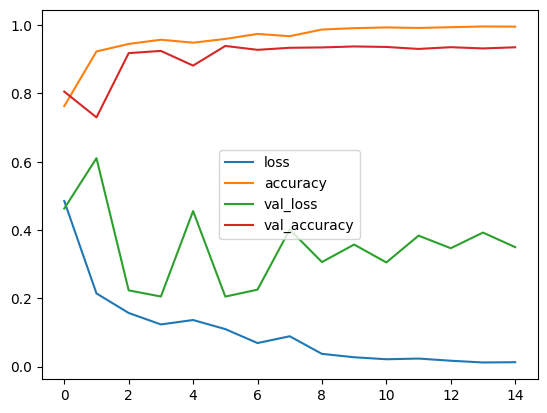

In [ ]:
import pandas as pd
pd.DataFrame(history.history).plot()

In [ ]:
test_dataset = test_dataset.batch(1)

In [ ]:
test_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [ ]:
model.evaluate(test_dataset)

4133/4133 [==============================] - 24s 4ms/step - loss: 0.2884 - accuracy: 0.9422


[0.2883981764316559, 0.9421727657318115]

In [ ]:
def parasite_or_not(x):
  if (x<.50):
    return str('P')
  else:
    return str('U')

1/1 [==============================] - 0s 18ms/step


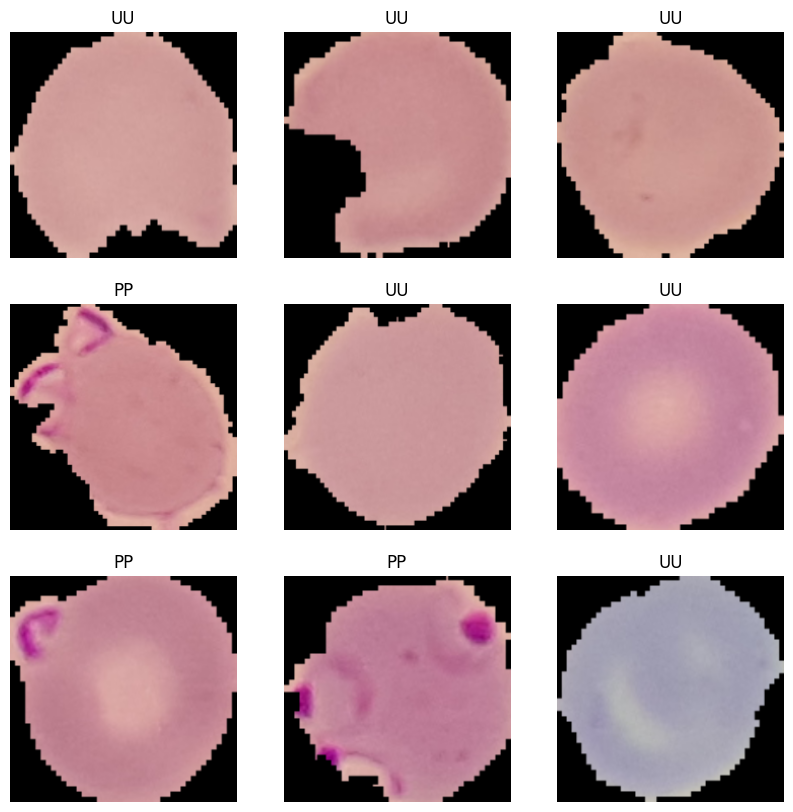

In [ ]:
plt.figure(figsize=(10, 10))

for i, (image, label) in enumerate(test_dataset.take(9)):
  plt.subplot(3, 3, i+1)
  plt.imshow(image[0])
  plt.title(str(parasite_or_not(label.numpy()[0])) + str(parasite_or_not(model.predict(image)[0][0])))
  plt.axis('off')

Functional API

In [ ]:
inputs = tf.keras.layers.Input(shape=(img_size, img_size, 3), name='input_layer')
x = Conv2D(filters=6, kernel_size=5, strides=(1, 1), padding='valid', activation='relu')(inputs)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2,2), strides=2)(x)

x = Conv2D(filters=16, kernel_size=5, strides=(1,1), padding='valid', activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2), strides=2)(x)

x = Flatten()(x)
x = Dense(100, activation = 'relu')(x)
x = BatchNormalization()(x)
x = Dense(10, activation='relu')(x)
outputs = Dense(1, activation = 'sigmoid')(x)

func_model = tf.keras.Model(inputs, outputs, name='lenet_model_funtional')
func_model.summary()

Model: "lenet_model_funtional"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_2 (Conv2D)           (None, 220, 220, 6)       456       
                                                                 
 batch_normalization_3 (Bat  (None, 220, 220, 6)       24        
 chNormalization)                                                
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 110, 110, 6)       0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 106, 106, 16)      2416      
                                                                 
 batch_normalization_4 (Bat  (None, 106, 106,

Hybrid model using Sequential API and Functional API

In [ ]:
feature_extractor = tf.keras.Sequential([
    #InputLayer(input_shape=(img_size, img_size, 3)),
    Conv2D(filters=6, kernel_size=5, strides=(1, 1), padding='valid', activation='relu'),
    BatchNormalization(),
    MaxPool2D(pool_size=(2, 2), strides=2),

    Conv2D(filters=16, kernel_size=5, strides=(1, 1), padding='valid', activation='relu'),
    BatchNormalization(),
    MaxPool2D(pool_size=(2, 2), strides=2)
])

In [ ]:
inputs = tf.keras.layers.Input(shape=(img_size, img_size, 3), name='input_layer')
x = feature_extractor(inputs)
x = Flatten()(x)
x = Dense(100, activation = 'relu')(x)
x = BatchNormalization()(x)
x = Dense(10, activation='relu')(x)
outputs = Dense(1, activation = 'sigmoid')(x)

hybrid_model = tf.keras.Model(inputs, outputs, name='lenet_model_hybrid')
hybrid_model.summary()

Model: "lenet_model_hybrid"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 53, 53, 16)        2960      
                                                                 
 flatten_2 (Flatten)         (None, 44944)             0         
                                                                 
 dense_6 (Dense)             (None, 100)               4494500   
                                                                 
 batch_normalization_8 (Bat  (None, 100)               400       
 chNormalization)                                                
                                                                 
 dense_7 (Dense)             (None, 10)                1010      
                                                

Model Subclassing

In [ ]:
class FeatureExtractor(Layer):
  def __init__(self, filters, kernel_size, strides, padding, activation, pool_size):
    super(FeatureExtractor, self).__init__()

    self.Conv2D_1 = Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, padding=padding, activation=activation)
    self.batch_normalization_1 = BatchNormalization()
    self.MaxPool2D_1 =  MaxPool2D(pool_size=pool_size, strides=2*strides)

    self.Conv2D_2 = Conv2D(filters=2*filters, kernel_size=kernel_size, strides=strides, padding=padding, activation=activation)
    self.batch_normalization_2 = BatchNormalization()
    self.MaxPool2D_2 =  MaxPool2D(pool_size=pool_size, strides=2*strides)


  def call(self, x):
    x = self.Conv2D_1(x)
    x = self.batch_normalization_1(x)
    x = self.MaxPool2D_1(x)

    x = self.Conv2D_2(x)
    x = self.batch_normalization_2(x)
    x = self.MaxPool2D_2(x)
    return x
feature_sub_classed = FeatureExtractor(8, 3, 1, "valid", "relu", 2)


In [ ]:
func_input = Input(shape = (img_size, img_size, 3), name = "Input Image")

x = feature_sub_classed(func_input)

x = Flatten()(x)

x = Dense(100, activation = "relu")(x)
x = BatchNormalization()(x)

x = Dense(10, activation = "relu")(x)
x = BatchNormalization()(x)

func_output = Dense(1, activation = "sigmoid")(x)

lenet_model_func = Model(func_input, func_output, name = "Lenet_Model")
lenet_model_func.summary()


Model: "Lenet_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input Image (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 feature_extractor (Feature  (None, 54, 54, 16)        1488      
 Extractor)                                                      
                                                                 
 flatten_3 (Flatten)         (None, 46656)             0         
                                                                 
 dense_9 (Dense)             (None, 100)               4665700   
                                                                 
 batch_normalization_11 (Ba  (None, 100)               400       
 tchNormalization)                                               
                                                                 
 dense_10 (Dense)            (None, 10)                

In [ ]:
class LenetModel(Model):
  def __init__(self):
    super(LenetModel, self).__init__()

    self.feature_extractor = FeatureExtractor(8, 3, 1, "valid", "relu", 2)
    self.flatten = Flatten()
    self.dense_1 = Dense(100, activation = 'relu')
    self.batch = BatchNormalization()
    self.dense_2 = Dense(10, activation = 'relu')
    self.batch_2 = BatchNormalization()
    self.dense_3 = Dense(1, activation = 'sigmoid')

  def call(self, x):
    x = self.feature_extractor(x)
    x = self.flatten(x)
    x = self.dense_1(x)
    x = self.batch(x)
    x = self.dense_2(x)
    x = self.batch_2(x)
    x = self.dense_3(x)

    return x

lenet_subclass_model = LenetModel()
lenet_subclass_model(tf.zeros([1, 224, 224, 3]))
lenet_subclass_model.summary()

Model: "lenet_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extractor_1 (Featu  multiple                  1488      
 reExtractor)                                                    
                                                                 
 flatten_4 (Flatten)         multiple                  0         
                                                                 
 dense_12 (Dense)            multiple                  4665700   
                                                                 
 batch_normalization_15 (Ba  multiple                  400       
 tchNormalization)                                               
                                                                 
 dense_13 (Dense)            multiple                  1010      
                                                                 
 batch_normalization_16 (Ba  multiple                  

Custom NN Layer

In [ ]:
class NeuralDense(Layer):
  def __init__(self, units, activation):
    super(NeuralDense, self).__init__()
    self.units = units
    self.activation = activation

  def build(self, input_feature_shape):
    self.w = self.add_weight(shape=(input_feature_shape[-1], self.units), initializer = 'random_normal', trainable = True)
    self.b = self.add_weight(shape=(self.units, ), initializer = 'random_normal', trainable = True)

  def call(self, input_features):
    pre_output = tf.matmul(input_features, self.w) + self.b

    # Activation
    if(self.activation=='relu'):
      return tf.nn.relu(pre_output)

    elif(self.activation=='sigmoid'):
      return tf.math.sigmoid(pre_output)

    else:
      return pre_output


In [ ]:
class LenetCustomModel(Model):
  def __init__(self):
    super(LenetCustomModel, self).__init__()

    self.feature_extractor = FeatureExtractor(8, 3, 1, "valid", "relu", 2)
    self.flatten = Flatten()
    self.dense_1 = NeuralDense(100, activation = 'relu')
    self.batch = BatchNormalization()
    self.dense_2 = NeuralDense(10, activation = 'relu')
    self.batch_2 = BatchNormalization()
    self.dense_3 = NeuralDense(1, activation = 'sigmoid')

  def call(self, x):
    x = self.feature_extractor(x)
    x = self.flatten(x)
    x = self.dense_1(x)
    x = self.batch(x)
    x = self.dense_2(x)
    x = self.batch_2(x)
    x = self.dense_3(x)

    return x

lenet_custon_subclass_model = LenetCustomModel()
lenet_custon_subclass_model(tf.zeros([1, 224, 224, 3]))
lenet_custon_subclass_model.summary()

Model: "lenet_custom_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extractor_2 (Featu  multiple                  1488      
 reExtractor)                                                    
                                                                 
 flatten_5 (Flatten)         multiple                  0         
                                                                 
 neural_dense (NeuralDense)  multiple                  4665700   
                                                                 
 batch_normalization_19 (Ba  multiple                  400       
 tchNormalization)                                               
                                                                 
 neural_dense_1 (NeuralDens  multiple                  1010      
 e)                                                              
                                                

Applying learning rate scheduler and early stopping callbacks

In [ ]:
# Compile the model

lennet_custom_model = LenetCustomModel()
lennet_custom_model.compile(
    optimizer = Adam(),
    loss = BinaryCrossentropy(),
    metrics = 'accuracy'
)

In [ ]:
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-5 * 10**(epoch/20))

In [ ]:
lennet_custom_history = lennet_custom_model.fit(
    train_dataset,
    validation_data = val_dataset,
    epochs = 60,
    callbacks = [lr_scheduler]
)

Epoch 1/60
603/603 [==============================] - 54s 85ms/step - loss: 0.6605 - accuracy: 0.6238 - val_loss: 0.6447 - val_accuracy: 0.6576 - lr: 1.0000e-05
Epoch 2/60
603/603 [==============================] - 43s 72ms/step - loss: 0.6329 - accuracy: 0.6731 - val_loss: 0.6279 - val_accuracy: 0.6892 - lr: 1.1220e-05
Epoch 3/60
603/603 [==============================] - 49s 82ms/step - loss: 0.6117 - accuracy: 0.7093 - val_loss: 0.6102 - val_accuracy: 0.7221 - lr: 1.2589e-05
Epoch 4/60
603/603 [==============================] - 42s 69ms/step - loss: 0.5854 - accuracy: 0.7486 - val_loss: 0.5837 - val_accuracy: 0.7620 - lr: 1.4125e-05
Epoch 5/60
603/603 [==============================] - 42s 69ms/step - loss: 0.5502 - accuracy: 0.7902 - val_loss: 0.5487 - val_accuracy: 0.7901 - lr: 1.5849e-05
Epoch 6/60
603/603 [==============================] - 47s 78ms/step - loss: 0.5088 - accuracy: 0.8262 - val_loss: 0.5065 - val_accuracy: 0.8189 - lr: 1.7783e-05
Epoch 7/60
603/603 [==============

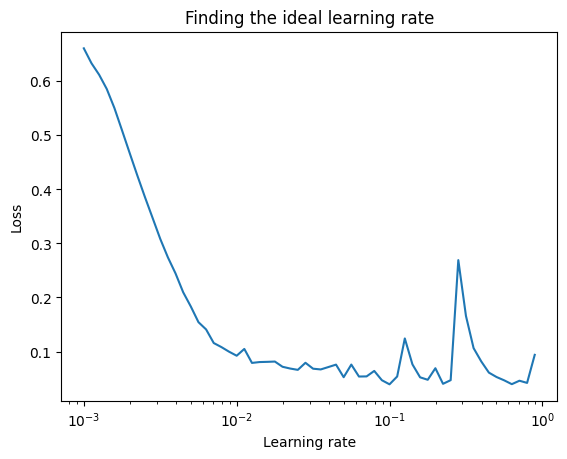

In [ ]:
# Plot the learning rate decay curve
import numpy as np
import matplotlib.pyplot as plt
lrs = 1e-3 * (10**(np.arange(60)/20))
plt.semilogx(lrs, lennet_custom_history.history["loss"]) # want the x-axis to be log-scale
plt.xlabel("Learning rate")
plt.ylabel("Loss")
plt.title("Finding the ideal learning rate");

In [ ]:
lennet_custom_model.compile(
    optimizer = Adam(lr=0.005),
    loss = BinaryCrossentropy(),
    metrics = 'accuracy'
)

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                  patience=5)

In [ ]:
lennet_custom_history = lennet_custom_model.fit(
    train_dataset,
    validation_data = val_dataset,
    epochs = 30,
    callbacks = [early_stopping]
)

Epoch 1/30
603/603 [==============================] - 47s 72ms/step - loss: 0.0841 - accuracy: 0.9694 - val_loss: 0.2709 - val_accuracy: 0.9115
Epoch 2/30
603/603 [==============================] - 42s 69ms/step - loss: 0.0430 - accuracy: 0.9855 - val_loss: 0.2985 - val_accuracy: 0.9190
Epoch 3/30
603/603 [==============================] - 43s 71ms/step - loss: 0.0182 - accuracy: 0.9947 - val_loss: 0.3481 - val_accuracy: 0.9216
Epoch 4/30
603/603 [==============================] - 43s 72ms/step - loss: 0.0094 - accuracy: 0.9973 - val_loss: 0.3436 - val_accuracy: 0.9291
Epoch 5/30
603/603 [==============================] - 47s 78ms/step - loss: 0.0059 - accuracy: 0.9987 - val_loss: 0.3820 - val_accuracy: 0.9267
Epoch 6/30
603/603 [==============================] - 42s 70ms/step - loss: 0.0082 - accuracy: 0.9975 - val_loss: 0.4150 - val_accuracy: 0.9258


<Axes: >

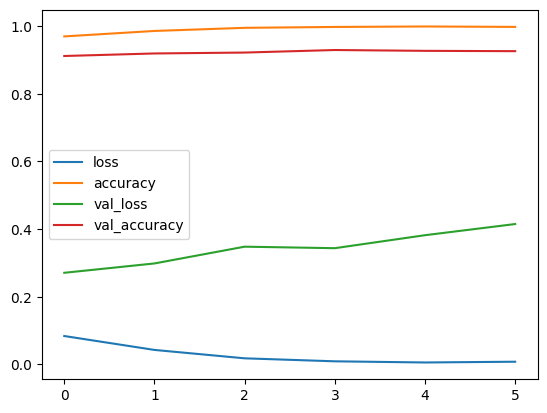

In [ ]:
import pandas as pd
pd.DataFrame(lennet_custom_history.history).plot()